In [1]:
import statsmodels.formula.api as smf
import statsmodels as sm
import numpy as np
import cPickle
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('/Users/zbutler/research/fire_prediction')
import prediction.poisson_regression as pr
%matplotlib inline

In [68]:
# First, load our dataset
with open('data/global_df.pkl') as fpkl:
    global_df = cPickle.load(fpkl)
summer_df = global_df[(global_df.dayofyear >= 134) & (global_df.dayofyear <= 242)]
summer_df[0:10]

,day,dayofyear,humidity,month,n_clusters,n_det,temp,vpd,year
27,15,134,69.719748,5,0,0,280.113025,0.421158,2010
28,16,135,72.449160,5,0,0,280.699440,0.399570,2010
29,17,136,71.776891,5,1,7,280.084874,0.396307,2010
30,18,137,67.335014,5,2,9,282.131653,0.520026,2010
31,19,138,63.952241,5,2,107,283.857283,0.657854,2010
32,20,139,63.493417,5,3,27,284.309804,0.705236,2010
33,21,140,66.646078,5,4,8,283.376050,0.562632,2010
34,22,141,59.812745,5,2,31,285.993417,0.823788,2010
35,23,142,63.460364,5,1,6,284.583473,0.672060,2010
36,24,143,65.049580,5,1,1,284.190056,0.620077,2010


In [172]:
# Convert into processing-friendly DataFrame
reload(pr)
autocorrs = [1,3,5,10]
print summer_df.loc[lambda x: (x.year==2010) & (x.dayofyear==134), 'n_det']
X, y, y_dates = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd', 'humidity', 'dayofyear', 'year'], normalize=[1,1,1,0,0], log_counts=True, autocorr_windows=autocorrs)
# Add our prediction target as a column for easier model prototyping
X.loc[:,'y'] = y
X1_train, y1_train, X1_test, y1_test = pr.train_test_split(X,y)
X2_train, y2_train, X2_test, y2_test = pr.train_test_split(X,y)
print X.loc[0:10]

27    0
Name: n_det, dtype: int64
Old df had 762 rows, new one without nans has 739
     n_det_1   n_det_3   n_det_5  n_det_10  normtemp   normvpd  normhumidity  \
0   0.693147  3.465736  3.332205  0.000000 -0.739954 -0.361175      0.139279   
1   1.791759  1.945910  2.197225  0.000000 -0.343657  0.123923     -0.266653   
2   3.970292  0.693147  3.465736  2.079442  0.200548  0.578950     -0.656887   
3   5.105945  1.791759  1.945910  2.302585  0.759597  1.478497     -1.638235   
4   6.035481  3.970292  0.693147  4.682131  0.600367  1.240071     -1.428790   
5   6.369901  5.105945  1.791759  3.332205  0.891906  1.641281     -1.722087   
6   6.079933  6.035481  3.970292  2.197225  0.851744  1.617921     -1.641602   
7   5.934894  6.369901  5.105945  3.465736  0.168878  0.530835     -0.673071   
8   5.780744  6.079933  6.035481  1.945910 -0.801501 -0.401364     -0.012549   
9   5.135798  5.934894  6.369901  0.693147 -0.197668  0.241892     -0.955728   
10  4.753590  5.780744  6.079933  1.

In [279]:
reload(pr)
# Now run various versions of the model 
covars = ['t', 'v', 'h', 'tv', '+tv', 'th', '+th', 'vh', '+vh', 'tvh']
res = smf.glm('y ~ n_det_1', data=X1_train, family=sm.genmod.families.family.Poisson()).fit()
y1_hat_base = res.predict(X1_test)
print pearsonr(y1_hat_base, y1_test)
#y_hat_base = X1_test.n_det_1
print "Method\tTrain LL\tMSE\tMedianSE\tMeanAbsErr\tRobustMSE"
print "Base\t%.2f\t" % (res.llf),
eval_metrics = ['MSE', 'MedianSE', 'MeanAbsErr', 'RobustMSE']
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y1_test, y_hat_base, metric=met),
print ""
for covar in covars:
    form = 'y ~ n_det_1 + '
    int_flag = 0
    for i,letter in enumerate(covar):
        if letter == "+":
            int_flag = 1
            continue
        if letter == 't':
            form += 'normtemp'
        elif letter == 'v':
            form += 'normvpd'
        elif letter == 'h':
            form += 'normhumidity'
        if i != len(covar) - 1:
            if int_flag:
                form += ' * '
            else:
                form += ' + '
    res = smf.glm(form, data=X1_train, family=sm.genmod.families.family.Poisson()).fit()
    y1_hat = res.predict(X1_test)
    print pearsonr(y1_hat, y1_test)
    print "%s\t%.2f\t" % (covar, res.llf),
    for met in eval_metrics:
        print "%.2f\t" % pr.evaluate_glm(y1_test, y1_hat, metric=met),
    print ""


(0.56465161184130674, 9.8225369961854321e-13)
Method	Train LL	MSE	MedianSE	MeanAbsErr	RobustMSE
Base	-21323.94	101754.31	102336.90	318.98	101895.37	
(0.57172408417048626, 4.4082449963380219e-13)
t	-18425.11	41074.64	34.78	69.04	2872.20	
(0.58501695357456018, 9.2751990432134019e-14)
v	-18864.63	41323.47	25.44	68.35	2494.67	
(0.62176107911742995, 8.4370372978437621e-16)
h	-18548.44	34526.25	24.61	66.06	2919.65	
(0.56909166249314613, 5.9531409292828538e-13)
tv	-18418.14	41110.71	38.68	69.15	2943.33	
(0.56768470801734905, 6.9825082852406552e-13)
+tv	-18417.59	41402.12	36.60	69.28	2933.16	
(0.59766211610878905, 1.9686861665734075e-14)
th	-18139.08	37954.30	30.53	67.53	2843.78	
(0.58219627965219678, 1.298778541868303e-13)
+th	-17982.64	41814.59	26.37	68.64	2720.24	
(0.61406282356242003, 2.376213842515489e-15)
vh	-18513.64	36062.22	26.78	66.56	2812.58	
(0.6136024945840487, 2.5257374100588888e-15)
+vh	-18513.34	36208.99	27.67	66.65	2808.83	
(0.6008529834362667, 1.3170951402854337e-14)
tvh	-175

In [202]:
# Now, similar expt but with different autocorrs
y_hat_base = X1_test.n_det_1
print "Method\tTrain LL\tMSE\tMedianSE\tMeanAbsErr\tRobustMSE"
print "Base\tN/A\t",
eval_metrics = ['MSE', 'MedianSE', 'MeanAbsErr', 'RobustMSE']
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y1_test, y_hat_base, metric=met),
print ""
for cor in autocorrs:
    form = 'y ~ n_det_%d + normtemp + normvpd' % cor
    res = smf.glm(form, data=X1_train, family=sm.genmod.families.family.Poisson()).fit()
    y1_hat = res.predict(X1_test)
    print "auto %d\t%.2f\t" % (cor, res.llf),
    for met in eval_metrics:
        print "%.2f\t" % pr.evaluate_glm(y1_test, y1_hat, metric=met),
    print ""
    #res = smf.glm(form, data=X2_train, family=sm.genmod.families.family.Poisson()).fit()
    #print "(2) Form: %s Train LL: %f Train BIC: %f " % (form, res.llf, res.bic)
    #y2_hat = res.predict(X2_test)
    #print "\tMSE: %f, Log MSE: %f" % (pr.evaluate_glm(y2_test, y2_hat), pr.evaluate_glm(y2_test, y2_hat, log=True))
#res = smf.glm("y ~ n_det_5 + normtemp + normvpd + normhumidity", data=X2_train, family=sm.genmod.families.family.Poisson()).fit()
#y2_hat = res.predict(X2_test)
#print np.mean((y2_test - y2_hat)**2)

Method	Train LL	MSE	MedianSE	MeanAbsErr	RobustMSE
Base	N/A	101754.31	102336.90	318.98	101895.37	
auto 1	-18418.14	41110.71	38.68	69.15	2943.33	
auto 3	-30995.73	59232.94	256.71	81.73	3351.77	
auto 5	-28851.38	57985.95	247.81	84.70	3816.71	
auto 10	-40446.32	219324.54	360.30	120.56	3893.84	


In [157]:
from scipy.stats import pearsonr
res = smf.glm("y ~ n_det_3 + normtemp + normvpd + normhumidity", data=X2_train, family=sm.genmod.families.family.Poisson()).fit()
print res.params
y2_hat = res.predict(X2_test)
print np.mean((y2_test - y2_hat)**2)
res = smf.glm("y ~ n_det_5 + normtemp + normvpd + normhumidity", data=X2_train, family=sm.genmod.families.family.Poisson()).fit()
print res.params
y2_hat = res.predict(X2_test)
print np.mean((y2_test - y2_hat)**2)

Intercept       1.428972
n_det_3         0.468020
normtemp        1.750676
normvpd        -1.435564
normhumidity   -1.545348
dtype: float64
38488.8579213
Intercept       1.664862
n_det_5         0.434568
normtemp        1.438979
normvpd        -0.812336
normhumidity   -1.135160
dtype: float64
24116.9336037


In [47]:
summer_df.loc[0] = summer_df.loc[27]
print summer_df.loc[0]

day               15.000000
dayofyear        134.000000
humidity          69.719748
month              5.000000
n_clusters         0.000000
n_det              0.000000
temp             280.113025
vpd                0.421158
year            2010.000000
normtemp          -2.084018
normvpd           -1.263489
normhumidity       1.213403
Name: 0, dtype: float64


/Users/zbutler/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [158]:
annual_dfs = dict()
years = range(2010,2017)
for year in years:
    annual_dfs[year] = X[X.year==year]

In [214]:
params_dict = dict()
for year in years:
    glm = smf.glm('y ~ n_det_1 + normvpd', data=annual_dfs[year], family=sm.genmod.families.family.Poisson()).fit()
    params_dict[year] = glm.params
print glm.params

Intercept    0.871947
n_det_1      0.483835
normvpd      1.051406
dtype: float64


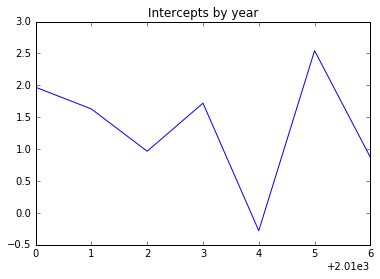

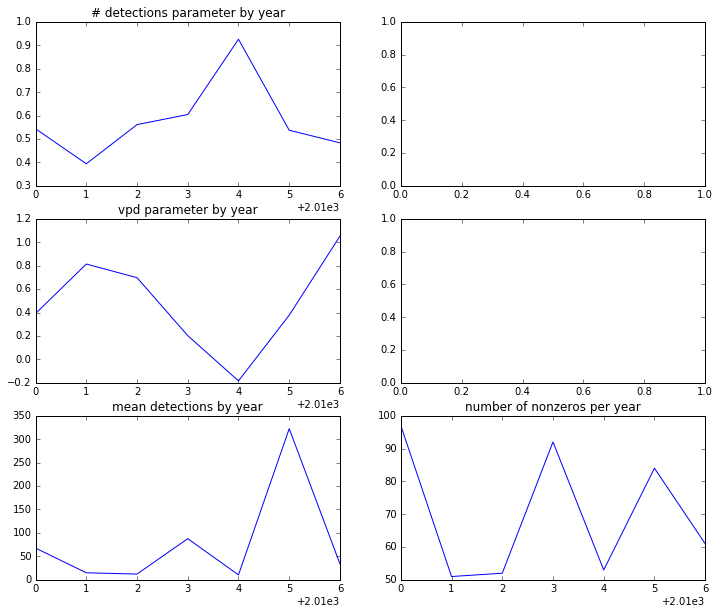

In [216]:
dets = []
temps = []
vpds = []
hums = []
intercepts = []
mean_dets = []
nnzs = []
for year in years:
    dets.append(params_dict[year].n_det_1)
#    temps.append(params_dict[year].normtemp)
    vpds.append(params_dict[year].normvpd)
#    hums.append(params_dict[year].normhumidity)
    mean_dets.append(np.mean(summer_df[summer_df.year==year].n_det))
    nnzs.append(np.sum(summer_df[summer_df.year==year].n_det > 0))
    intercepts.append(params_dict[year].Intercept)

plt.plot(years, intercepts)
plt.title('Intercepts by year')
plt.savefig('pics/intercepts_by_year.png')
plt.show()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
plt.subplot(321)
plt.plot(years, dets)
plt.title("# detections parameter by year")
#plt.subplot(322)
#plt.plot(years, temps)
#plt.title("temp parameter by year")
plt.subplot(323)
plt.plot(years, vpds)
plt.title("vpd parameter by year")
#plt.subplot(324)
#plt.plot(years, hums)
#plt.title("humidity parameter by year")
plt.subplot(325)
plt.plot(years, mean_dets)
plt.title("mean detections by year")
plt.subplot(326)
plt.plot(years, nnzs)
plt.title("number of nonzeros per year")
plt.savefig("pics/other_params_by_year.png")
plt.show()

In [164]:
Xnl, ynl, ynl_dates = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd', 'humidity', 'dayofyear', 'year'], normalize=[1,1,1,0,0], log_counts=False, autocorr_windows=autocorrs)
for cor in autocorrs:
    X.loc[:,'n_det_%d_nl' %cor] = Xnl['n_det_%d' %cor]
# Add our prediction target as a column for easier model prototyping
X.loc[:,'y'] = y
X1_train, y1_train, X1_test, y1_test = pr.train_test_split(X,y)
X2_train, y2_train, X2_test, y2_test = pr.train_test_split(X,y)
print X.iloc[0:10]

Old df had 762 rows, new one without nans has 739
    n_det_1   n_det_3   n_det_5  n_det_10  normtemp   normvpd  normhumidity  \
0  0.693147  3.465736  3.332205  0.000000 -0.739954 -0.361175      0.139279   
1  1.791759  1.945910  2.197225  0.000000 -0.343657  0.123923     -0.266653   
2  3.970292  0.693147  3.465736  2.079442  0.200548  0.578950     -0.656887   
3  5.105945  1.791759  1.945910  2.302585  0.759597  1.478497     -1.638235   
4  6.035481  3.970292  0.693147  4.682131  0.600367  1.240071     -1.428790   
5  6.369901  5.105945  1.791759  3.332205  0.891906  1.641281     -1.722087   
6  6.079933  6.035481  3.970292  2.197225  0.851744  1.617921     -1.641602   
7  5.934894  6.369901  5.105945  3.465736  0.168878  0.530835     -0.673071   
8  5.780744  6.079933  6.035481  1.945910 -0.801501 -0.401364     -0.012549   
9  5.135798  5.934894  6.369901  0.693147 -0.197668  0.241892     -0.955728   

   dayofyear    year    y  n_det_1_nl  n_det_3_nl  n_det_5_nl  n_det_10_nl  
0  

In [171]:
res = smf.glm(form, data=X1_train, family=sm.genmod.families.family.Poisson()).fit()
y1_hat = res.predict(X1_test)
print y1_hat.shape
y_hat_base = X1_test.n_det_1_nl
print "MSE base: " + str(pr.evaluate_glm(y1_test, y_hat_base))
for cor in autocorrs:
    form = 'y ~ n_det_%d + normtemp + normvpd + normhumidity' % cor
    res = smf.glm(form, data=X1_train, family=sm.genmod.families.family.Poisson()).fit()
    print "(log) Form: %s Train LL: %f Train BIC: %f " % (form, res.llf, res.bic)
    y1_hat = res.predict(X1_test)
    print "\tMSE: %f, Log MSE: %f" % (pr.evaluate_glm(y1_test, y1_hat), pr.evaluate_glm(y1_test, y1_hat, log=True))
    
    form = 'y ~ n_det_%d_nl + normtemp + normvpd + normhumidity' % cor
    res = smf.glm(form, data=X1_train, family=sm.genmod.families.family.Poisson()).fit()
    print "(nolog) Form: %s Train LL: %f Train BIC: %f " % (form, res.llf, res.bic)
    y1_hat = res.predict(X1_test)
    print "\tMSE: %f, Log MSE: %f" % (pr.evaluate_glm(y1_test, y1_hat), pr.evaluate_glm(y1_test, y1_hat, log=True))

res = smf.glm("y ~ n_det_5 + normtemp + normvpd + normhumidity", data=X2_train, family=sm.genmod.families.family.Poisson()).fit()
y2_hat = res.predict(X2_test)
print np.mean((y2_test - y2_hat))**2

(135,)
MSE base: 16267.2444444
(log) Form: y ~ n_det_1 + normtemp + normvpd + normhumidity Train LL: -20646.687585 Train BIC: 36197.678882 
	MSE: 9333.178743, Log MSE: 4.256507
(nolog) Form: y ~ n_det_1_nl + normtemp + normvpd + normhumidity Train LL: -41802.503247 Train BIC: 78509.310208 
	MSE: 18032.104369, Log MSE: 6.742409
(log) Form: y ~ n_det_3 + normtemp + normvpd + normhumidity Train LL: -31253.167789 Train BIC: 57410.639291 
	MSE: 15202.037331, Log MSE: 5.384284
(nolog) Form: y ~ n_det_3_nl + normtemp + normvpd + normhumidity Train LL: -43961.799988 Train BIC: 82827.903688 
	MSE: 20046.440244, Log MSE: 6.487281
(log) Form: y ~ n_det_5 + normtemp + normvpd + normhumidity Train LL: -32185.081017 Train BIC: 59274.465746 
	MSE: 5609.080808, Log MSE: 5.727989
(nolog) Form: y ~ n_det_5_nl + normtemp + normvpd + normhumidity Train LL: -46965.542616 Train BIC: 88835.388945 
	MSE: 9789.300049, Log MSE: 6.591989
(log) Form: y ~ n_det_10 + normtemp + normvpd + normhumidity Train LL: -432

prediction/poisson_regression.py:152: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  y_hat = y_hat[non_nans]


In [142]:
# Now, try binary model
reload(pr)
X, y, nz_X, nz_y, bin_y = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd', 'humidity', 'dayofyear', 'year'], normalize=[1,1,1,0,0], log_counts=True, autocorr_windows=autocorrs, ignore_nans=True, return_alt_ys=True)
res_nz = smf.glm("y ~ n_det_1 + normvpd", data=nz_X, family=sm.genmod.families.family.Poisson()).fit()
res_z = smf.glm("bin_y ~ n_det_1 + normvpd", data=X, family=sm.genmod.families.family.Binomial()).fit()
print res_nz.summary()
print res_z.summary()



Old df had 762 rows, new one without nans has 739
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  427
Model:                            GLM   Df Residuals:                      422
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -22542.
Date:                Thu, 11 May 2017   Deviance:                       42998.
Time:                        15:13:29   Pearson chi2:                 6.55e+04
No. Iterations:                     9                                         
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 1.5262      0.016     97.989     

In [145]:
print np.sum(bin_y)
print len(bin_y)

427
674


In [175]:
reload(pr)
Xun, yun, yun_dates = pr.get_regression_df(summer_df, covar_cols=['temp', 'vpd', 'humidity', 'dayofyear', 'year'], normalize=[2,2,2,0,0], log_counts=True, autocorr_windows=autocorrs)
print Xun.iloc[0:5]
# Add our prediction target as a column for easier model prototyping
Xun.loc[:,'humidity'] /= 100.
Xun_train, yun_train, Xun_test, yun_test = pr.train_test_split(Xun,yun)
# Now run various versions of the model 
covars = ['t', 'v', 'h', 'tv', 'th', 'vh', '+tv', '+th', '+vh', 'tvh']
for covar in covars:
    form = 'y ~ n_det_1 + '
    int_flag = 0
    for i,letter in enumerate(covar):
        if letter == "+":
            int_flag = 1
            continue
        if letter == 't':
            form += 'temp'
        elif letter == 'v':
            form += 'vpd'
        elif letter == 'h':
            form += 'humidity'
        if i != len(covar) - 1:
            if int_flag:
                form += ' * '
            else:
                form += ' + '
    res = smf.glm(form, data=Xun_train, family=sm.genmod.families.family.Poisson()).fit()
    print "(unnorm) Form: %s Train LL: %f Train BIC: %f " % (form, res.llf, res.bic)
    y1_hat = res.predict(Xun_test)
    print "\tMSE: %f, Log MSE: %f" % (pr.evaluate_glm(yun_test, y1_hat), pr.evaluate_glm(yun_test, y1_hat, log=True))
    
    form = 'y ~ n_det_1 + '
    int_flag = 0
    for i,letter in enumerate(covar):
        if letter == "+":
            int_flag = 1
            continue
        if letter == 't':
            form += 'normtemp'
        elif letter == 'v':
            form += 'normvpd'
        elif letter == 'h':
            form += 'normhumidity'
        if i != len(covar) - 1:
            if int_flag:
                form += ' * '
            else:
                form += ' + '
    res = smf.glm(form, data=Xun_train, family=sm.genmod.families.family.Poisson()).fit()
    print "(norm) Form: %s Train LL: %f Train BIC: %f " % (form, res.llf, res.bic)
    y1_hat = res.predict(Xun_test)
    print "\tMSE: %f, Log MSE: %f" % (pr.evaluate_glm(yun_test, y1_hat), pr.evaluate_glm(yun_test, y1_hat, log=True))

Old df had 762 rows, new one without nans has 739
    n_det_1   n_det_3   n_det_5  n_det_10  normtemp        temp   normvpd  \
0  0.693147  3.465736  3.332205  0.000000 -0.739954  286.098599 -0.361175   
1  1.791759  1.945910  2.197225  0.000000 -0.343657  287.863445  0.123923   
2  3.970292  0.693147  3.465736  2.079442  0.200548  290.286975  0.578950   
3  5.105945  1.791759  1.945910  2.302585  0.759597  292.776611  1.478497   
4  6.035481  3.970292  0.693147  4.682131  0.600367  292.067507  1.240071   

        vpd  normhumidity   humidity  dayofyear    year    y  
0  0.850241      0.139279  57.970308      144.0  2010.0    5  
1  1.080923     -0.266653  53.529972      145.0  2010.0   52  
2  1.297305     -0.656887  49.261345      146.0  2010.0  164  
3  1.725073     -1.638235  38.526751      147.0  2010.0  417  
4  1.611692     -1.428790  40.817787      148.0  2010.0  583  
(unnorm) Form: y ~ n_det_1 + temp Train LL: -19307.102357 Train BIC: 33574.619253 
	MSE: 68881.331814, Log MS

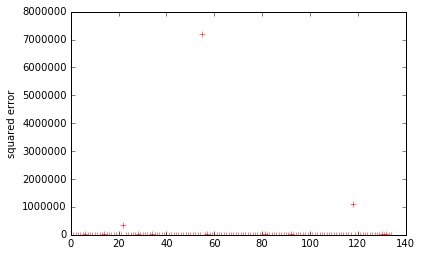

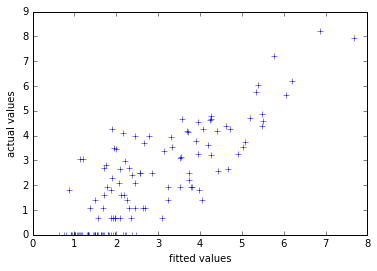

(0.83623027125728044, 1.6337688450969366e-36)
(0.84591653734560612, 3.976297087951679e-38)


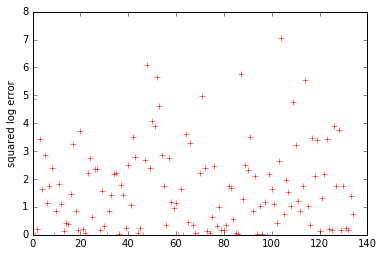

In [225]:
# Now look at where loss is coming from
res = smf.glm('y ~ n_det_1 + normtemp + normvpd + normhumidity', data=Xun_train, family=sm.genmod.families.family.Poisson()).fit()
y1_hat = res.predict(Xun_test)
plt.plot((y1_hat - yun_test)**2, 'r+')
plt.ylabel('squared error')
plt.show()
plt.plot(np.log(y1_hat+1), np.log(yun_test+1), 'b+')
plt.xlabel('fitted values')
plt.ylabel('actual values')
plt.show()
print pearsonr(np.log(y1_hat+1), np.log(yun_test+1))
print pearsonr(y1_hat, yun_test)
plt.plot((np.log(y1_hat+1) - np.log(yun_test+1))**2, 'r+')
plt.ylabel('squared log error')
plt.show()

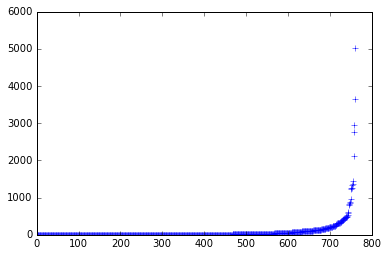

,day,dayofyear,humidity,month,n_clusters,n_det,temp,vpd,year
988,21,171,33.213726,6,70,1231,298.877045,2.364938,2015
989,22,172,34.554482,6,106,2106,298.915405,2.339218,2015
990,23,173,35.487675,6,125,2950,298.764709,2.284892,2015
991,24,174,35.660507,6,120,2768,298.540344,2.232876,2015
992,25,175,32.518349,6,126,5015,298.087280,2.260536,2015
996,29,179,46.520729,6,60,1270,292.810364,1.388394,2015
1001,4,184,51.783615,7,39,1343,292.065125,1.170808,2015
1003,6,186,38.676193,7,60,3651,298.373260,2.095687,2015
1008,11,191,44.535435,7,38,1376,293.768341,1.455246,2015
1009,12,192,43.844398,7,35,1252,294.387390,1.559688,2015


In [183]:
plt.plot(np.sort(summer_df.n_det),'b+')
plt.show()
summer_df[summer_df.n_det > 1000]

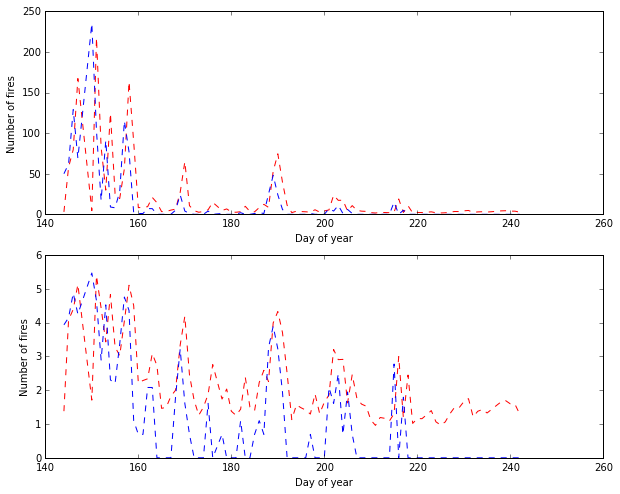

In [241]:
# plot preds vs reals by day. Train on all but 2013, predict 2013.
testyear = 2011
X_train = X[X.year != testyear]
y_train = X[X.year != testyear].y
X_test = X[X.year == testyear]
y_test = X[X.year == testyear].y
res = smf.glm('y ~ n_det_1 + normhumidity', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
y_hat = res.predict(X_test)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax1 = plt.subplot(211)
plt.plot(X_test.dayofyear, y_hat, 'r--')
plt.plot(X_test.dayofyear, y_test, 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(X_test.dayofyear, np.log(y_hat+1), 'r--')
plt.plot(X_test.dayofyear, np.log(y_test+1), 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
plt.show()

In [243]:
# Throw in lightning! Only for the three years we have it though
with open("data/lightning/ground_lightning.pkl") as fpkl:
    ground_l = cPickle.load(fpkl)
print "Loaded %d ground lightning strikes" % len(ground_l)
ground_l.iloc[0:10]

Loaded 386144 ground lightning strikes


,amplitude,day,lat,lon,millisec,month,stroketype,year
0,-900.0,6,59.734187,-159.665223,965,3,GROUND_STROKE,2012
1,-800.0,7,57.151463,-160.337396,213,3,GROUND_STROKE,2012
2,-1000.0,8,56.797220,-164.046543,735,3,GROUND_STROKE,2012
3,-5100.0,8,60.136043,-155.737774,635,3,GROUND_STROKE,2012
4,-400.0,8,62.559145,-148.119411,818,3,GROUND_STROKE,2012
5,-4700.0,10,55.303014,-153.730459,46,3,GROUND_STROKE,2012
6,-900.0,10,60.749635,-164.928437,762,3,GROUND_STROKE,2012
7,-1200.0,11,55.822369,-162.586637,458,3,GROUND_STROKE,2012
8,-1500.0,11,56.415247,-162.217703,203,3,GROUND_STROKE,2012
9,-2500.0,12,55.291613,-161.638156,469,3,GROUND_STROKE,2012


In [266]:
# Aggregate per day and make a new training dataset for 2012-2015 with lightning included
from util.daymonth import monthday2day, increment_day
X_1215 = X[(X.year < 2016) & (X.year > 2011)]
X_1215['lightning'] = pd.Series(np.zeros(len(X_1215)), index=X_1215.index)
day = 1
month = 1
year = 2012
strikes_per_day = []
while year < 2016:
    n_strikes = len(ground_l[(ground_l.day == day) & (ground_l.month == month) & (ground_l.year == year)])
    dayofyear = monthday2day(month, day, leapyear=(year % 4))
    if len(X_1215[(X_1215.dayofyear == dayofyear) & (X_1215.year == year)]):
        X_1215.lightning[(X_1215.dayofyear == dayofyear) & (X_1215.year == year)] = n_strikes
    year, month, day = increment_day(year, month, day)
X_1215['loglightning'] = np.log(X_1215.lightning + 1)
print X_1215.iloc[0:10]

/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


     n_det_1   n_det_3   n_det_5  n_det_10  normtemp   normvpd  normhumidity  \
195      0.0  0.000000  0.000000  1.098612 -0.982966 -0.835165      1.333669   
196      0.0  0.693147  0.000000  0.000000 -1.047437 -0.739664      1.162777   
197      0.0  0.000000  0.000000  0.000000 -1.615984 -1.291740      1.684890   
198      0.0  0.000000  0.693147  0.693147 -1.655579 -1.100203      1.160792   
199      0.0  0.000000  0.000000  0.000000 -1.476065 -1.028105      1.081895   
200      0.0  0.000000  0.000000  0.000000 -1.010421 -0.560360      0.523624   
201      0.0  0.000000  0.000000  0.000000 -1.262176 -0.832871      0.773541   
202      0.0  0.000000  0.000000  0.000000 -0.899844 -0.299256      0.050331   
203      0.0  0.000000  0.000000  0.693147 -0.793293 -0.422623      0.209687   
204      0.0  0.000000  0.000000  0.000000 -0.834806 -0.620510      0.467786   

     dayofyear    year  y  lightning  loglightning  
195      144.0  2012.0  0        0.0      0.000000  
196      145.

/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [270]:
# Ok, now predict 2013 from other years
testyear = 2013
X_train = X_1215[X_1215.year != testyear]
y_train = X_1215[X_1215.year != testyear].y
X_test = X_1215[X_1215.year == testyear]
y_test = X_1215[X_1215.year == testyear].y
res = smf.glm('y ~ n_det_1 + normhumidity + loglightning', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  295
Model:                            GLM   Df Residuals:                      291
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -14881.
Date:                Thu, 18 May 2017   Deviance:                       28943.
Time:                        15:37:44   Pearson chi2:                 4.02e+04
No. Iterations:                    10                                         
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        1.3417      0.023     59.049      0.000         1.297     1.386
n_det_1          0.6730      0.004    186.013      0.000         0.666     0.680
normhumidity    -0.4989      0.009    -58.336      0.000        -0.516    -0.482
loglightning     0.0251      0.002     10.536      0.000         0.020     0.030
================================================================================
"""

In [272]:
res0 = smf.glm('y ~ n_det_1', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
res1 = smf.glm('y ~ n_det_1 + normhumidity', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
res2 = smf.glm('y ~ n_det_1 + normhumidity + lightning', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
res3 = smf.glm('y ~ n_det_1 + normhumidity + loglightning', data=X_train, family=sm.genmod.families.family.Poisson()).fit()
y_hat0 = res0.predict(X_test)
y_hat1 = res1.predict(X_test)
y_hat2 = res2.predict(X_test)
y_hat3 = res3.predict(X_test)
print "Method\tTrain LL\tMSE\tMedianSE\tMeanAbsErr\tRobustMSE"
print "no covars\t%.2f\t" % (res0.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat0, metric=met),
print ""
print "no lightning\t%.2f\t" % (res1.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat1, metric=met),
print ""
print "lightning\t%.2f\t" % (res2.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat2, metric=met),
print ""
print "log lightning\t%.2f\t" % (res3.llf),
for met in eval_metrics:
    print "%.2f\t" % pr.evaluate_glm(y_test, y_hat3, metric=met),
print ""

Method	Train LL	MSE	MedianSE	MeanAbsErr	RobustMSE
no covars	-17000.85	13698.77	785.23	65.90	3765.20	
no lightning	-14937.93	35860.87	399.60	79.54	3847.77	
lightning	-14767.76	28809.08	390.09	74.37	3683.39	
log lightning	-14881.07	34614.39	407.18	79.15	3978.34	


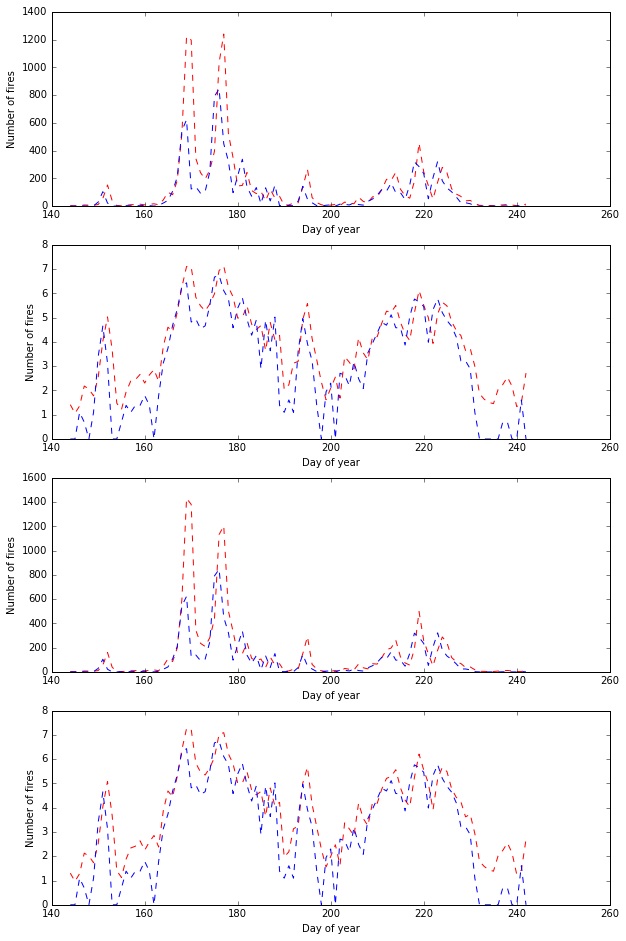

In [276]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,16))
ax1 = plt.subplot(411)
plt.plot(X_test.dayofyear, y_hat2, 'r--')
plt.plot(X_test.dayofyear, y_test, 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
ax2 = plt.subplot(412, sharex=ax1)
plt.plot(X_test.dayofyear, np.log(y_hat2+1), 'r--')
plt.plot(X_test.dayofyear, np.log(y_test+1), 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(X_test.dayofyear, y_hat1, 'r--')
plt.plot(X_test.dayofyear, y_test, 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
ax4 = plt.subplot(414, sharex=ax1)
plt.plot(X_test.dayofyear, np.log(y_hat1+1), 'r--')
plt.plot(X_test.dayofyear, np.log(y_test+1), 'b--')
plt.xlabel("Day of year")
plt.ylabel("Number of fires")
plt.show()

In [280]:
from util.daymonth import day2monthday
print day2monthday(134)
print day2monthday(242)

(5, 15)
(8, 31)
